#### Distribution of UTRon lengths
Looking at the distriubtion of intronic lengths for the following transcripts:
- novel UTRons
- all UTRons
- random selections of introns

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import subprocess


cnx = sqlite3.connect('/shared/sudlab1/General/projects/utrons_project/BladderCancerUtrons/431BladderUtrons.db')
cnx.execute("ATTACH '/shared/sudlab1/General/annotations/hg38_noalt_ensembl85/csvdb' as annotations")

In [2]:
# Get novel gene ids into a database 
query_text1 = """
    SELECT uid.transcript_id AS name, ti.gene_name AS gene
    FROM novel_utrons_ids AS uid
    INNER JOIN annotations.transcript_info AS ti
    ON ti.transcript_id = uid.match_transcript_id
    WHERE uid.transcript_id like "MSTRG%" AND uid.track="agg-agg-agg"
    ORDER BY uid.transcript_id
    """
novelUtronIds = pd.read_sql_query(query_text1, cnx)



#Output Ids to text file 
novelFilename = "/shared/sudlab1/General/projects/utrons_project/misc_files/novelUtronIds.unfiltered.txt"
novelFile = open(novelFilename, 'w')
for gene in novelUtronIds.ix[:,0].tolist():
    string = gene + "\n"
    novelFile.write(string)
novelFile.close()




# Get known Utron ids into a database
query_text1 = """
    SELECT uid.transcript_id AS name, ti.gene_name AS gene
    FROM all_utrons_ids AS uid
    INNER JOIN transcript_class AS tc
    ON tc.transcript_id = uid.transcript_id
    INNER JOIN annotations.transcript_info AS ti
    ON ti.transcript_id = tc.match_transcript_id
    WHERE uid.transcript_id like "ENS%" AND tc.track="agg-agg-agg"
    GROUP BY uid.transcript_id
    ORDER BY uid.transcript_id
    """
allUtronIds = pd.read_sql_query(query_text1, cnx)



# Output Ids to a text file
allFilename = "/shared/sudlab1/General/projects/utrons_project/misc_files/knownUtronIds.txt"
allFile = open(allFilename, 'w')
for gene in allUtronIds.ix[:,0].tolist():
    string = gene + "\n"
    allFile.write(string)
allFile.close()

In [3]:
# get novel ids into a list
a = novelUtronIds["name"].tolist()

# Open utrons bed file
novelBed = "/shared/sudlab1/General/projects/utrons_project/misc_files/UtronAnnotationFiles/agg-agg-agg.novel_utrons.bed"

# Open temp file to write filtered bed file to
novelBed2 = "./tempfiles/novelutronsfiltered.bed"
novelBedFiltered = open(novelBed2, 'w')


# Open novel bed file and if txnames in the list of novel ids write the line to a file
for line in open(novelBed).readlines():
    line = line.rstrip()
    f = line.split()
    txname = f[3][:-16]
    if txname in a:
        string = ""
        for col in f:
            string += col + "\t"
        string += "\n"
        novelBedFiltered.write(string)
novelBedFiltered.close()


# Open the file just written to and get the lengths into a list novelLengths
novelLengths = []
for line in open(novelBed2).readlines():
    f =line.split()
    point1 = int(f[1])
    point2 = int(f[2])
    length = point2 - point1
    novelLengths.append(length)

In [6]:
# get all utron names into a list
b = allUtronIds["name"].tolist()

# Filename of all utrons bed file
allBed = "/shared/sudlab1/General/projects/utrons_project/misc_files/UtronAnnotationFiles/agg-agg-agg.all_utrons.bed"

# Filename of temp file to write filtered data to
allBed2 = "./tempfiles/allutronsfiltered.bed"
allBedFiltered = open(allBed2, 'w')

# Loop through bed fiel and if the utron id is in the list of known utrons, write it to tempfile
txnames = []
for line in open(allBed).readlines():
    line = line.rstrip()
    f = line.split()
    txname = f[3]
    txnames.append(txname)
    if txname in b:
        string = ""
        for col in f:
            string += col + "\t"
        string += "\n"
        allBedFiltered.write(string)
allBedFiltered.close()


# Get lengths from tempfile
allLengths = []
for line in open(allBed2).readlines():
    f =line.split()
    point1 = int(f[1])
    point2 = int(f[2])
    length = point2 - point1
    allLengths.append(length)

In [7]:
# Get lengths of reference introns

# Open file with geneset_all intronic regions
genesetIntrons = "/shared/sudlab1/General/projects/utrons_project/misc_files/geneset_all.introns.gtf"

# Read file into dataframe
a = pd.read_csv(genesetIntrons, sep="\t", header=None)

#Get lengths as col4 - col3
a["length"] = a[4]  - a[3]
a = a["length"].copy()

Populating the interactive namespace from numpy and matplotlib


/home/mba13ns/anaconda2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


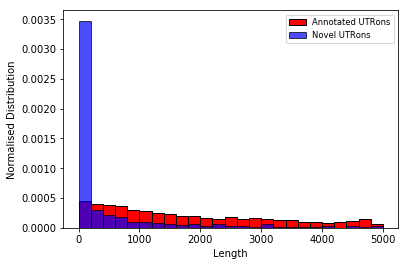

In [10]:
%pylab inline

# Plot vals
pylab.hist(allLengths, range=(0,5000), bins=25, color="red", normed=True, label="Annotated UTRons",edgecolor = "black" )
pylab.hist(novelLengths, range=(0,5000), bins=25, color="blue", normed=True, alpha=0.7, label="Novel UTRons", edgecolor = "black")

# Figure options
pylab.legend(fontsize="small")
pylab.xlabel("Length"); pylab.ylabel("Normalised Distribution")
pylab.savefig("./images/1_KnownVsNovelLengths_5000.png", dpi=300)

- Lots of UTRons at at <200 bp in length in comparison the the annotated UTRons 

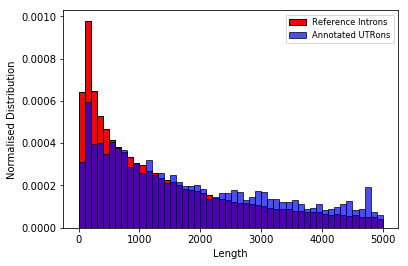

In [22]:
# Plot vals
pylab.hist(a.tolist(), bins=50, range=(0,5000), normed=True, color="red", label="Reference Introns",edgecolor = "black" )
pylab.hist(allLengths, bins=50, range=(0,5000), normed=True, color="blue", alpha=0.7, label="Annotated UTRons", edgecolor = "black")

# Figure options
pylab.legend(fontsize="small")
pylab.xlabel("Length"); pylab.ylabel("Normalised Distribution")
pylab.savefig("./images/1_KnownVsReference_5000.png", dpi=300)

- Reference annotations show a very similar distribution to the reference introns probably meaning that the novel UTRons assembled have different propoerties to the annotated UTRons

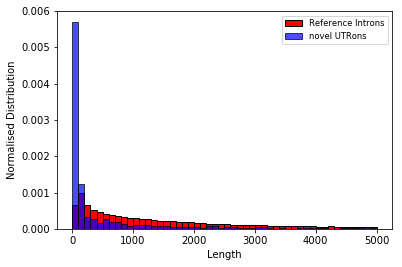

In [24]:
# Plot vals
pylab.hist(a.tolist(), bins=50, range=(0,5000), normed=True, color="red", label="Reference Introns", edgecolor = "black")
pylab.hist(novelLengths, bins=50, range=(0,5000), normed=True, color="blue", alpha=0.7, label="novel UTRons", edgecolor = "black")

# Figure Options
pylab.legend(fontsize="small")
pylab.xlabel("Length"); pylab.ylabel("Normalised Distribution")
pylab.savefig("./images/1_NovelVsReference.png", dpi=300)

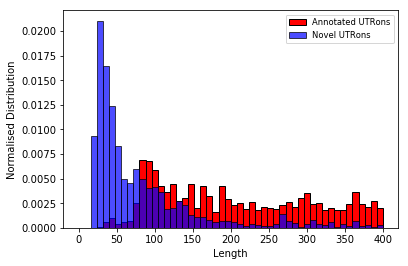

In [25]:
# Plot vals
pylab.hist(allLengths, range=(0,400), bins=50, color="red", normed=True, label="Annotated UTRons", edgecolor = "black")
pylab.hist(novelLengths, range=(0,400), bins=50, color="blue", normed=True, alpha=0.7, label="Novel UTRons", edgecolor = "black")

# Figure Options
pylab.legend(fontsize="small")
pylab.xlabel("Length"); pylab.ylabel("Normalised Distribution")
pylab.savefig("./images/1_NovelVsKnown_400", dpi=300)

- When looking at distr. of 0-400bp this confirms that lots of the utrons are short wheras only a few of the annotated UTRons are at short lengths

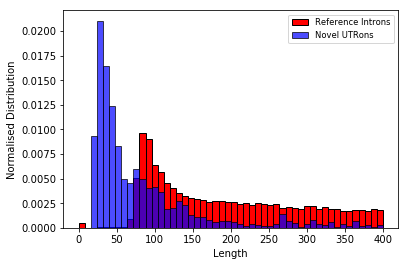

In [27]:
# Plot vals
pylab.hist(a.tolist(), range=(0,400), bins=50, color="red", normed=True, label="Reference Introns",edgecolor = "black")
pylab.hist(novelLengths, range=(0,400), bins=50, color="blue", normed=True, alpha=0.7, label="Novel UTRons",edgecolor = "black")

# Figure Options
pylab.legend(fontsize="small")
pylab.xlabel("Length"); pylab.ylabel("Normalised Distribution")
pylab.savefig("./images/1_NovelVsReference_400", dpi=300)

- Even fewer of the reference introns overlapping at short distances - maybe the known utrons which overlap at very short distances are actually deletions / not real 

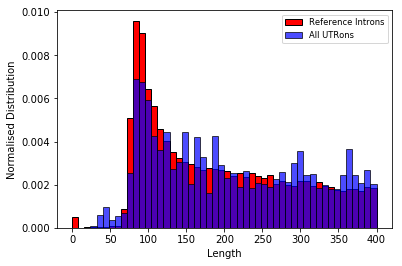

In [28]:
# Plot Vals
pylab.hist(a.tolist(), range=(0,400), bins=50, color="red", normed=True, label="Reference Introns", edgecolor = "black")
pylab.hist(allLengths, range=(0,400), bins=50, color="blue", normed=True, alpha=0.7, label="All UTRons", edgecolor = "black")

# Figure Options
pylab.legend(fontsize="small")
pylab.xlabel("Length"); pylab.ylabel("Normalised Distribution")
pylab.savefig("./images/1_AllVsReference_400", dpi=300)

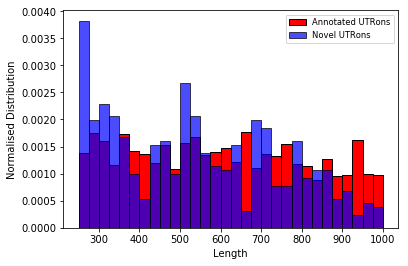

In [12]:
# Plot Vals
pylab.hist(allLengths, range=(250,1000), bins=30, color="red", normed=True, label="Annotated UTRons",edgecolor = "black")
pylab.hist(novelLengths, range=(250,1000), bins=30, color="blue", normed=True, alpha=0.7, label="Novel UTRons",edgecolor = "black")

# Figure Options
pylab.legend(fontsize="small")
pylab.xlabel("Length"); pylab.ylabel("Normalised Distribution")
pylab.savefig("./images/1_NovelVsKnown_250-1000", dpi=300)

 - When taking UTROns with length > 250 the distributions are much more similar - hopefully these have similar properties to known UTRons and are real

In [35]:
length = 75
print "proportion novel utrons > %sbp" % length
print float(len([x for x in novelLengths if x > length])) / len(novelLengths)

print "\nproportion all utrons > %sbp" % length
print float(len([x for x in allLengths if x > length])) / len(allLengths)

print "\nproportion reference introns > %sbp" % length
print float(len([x for x in a.tolist() if x > length])) / len(a)


proportion novel utrons > 75bp
0.526487367563

proportion all utrons > 75bp
0.996860842578

proportion reference introns > 75bp
0.993919548606


In [72]:
# Getting novel Utron tx names into csv files (for later use)


# Function to get txname for each tx
def getName(row):
    return row[3][:-16]


# Read bed file info into DF
a = pd.read_csv("/shared/sudlab1/General/projects/utrons_project/misc_files/UtronAnnotationFiles/agg-agg-agg.novel_utrons.bed", sep="\t", header=None)
a["length"] = a[2] - a[1]
a["txId"] = a.apply(getName, axis=1)

# Get lengths and tx ids into DF copy
novelUtrons = a[["length", "txId"]].copy()
novelUtrons = novelUtrons[novelUtrons["txId"].isin(novelUtronIds["name"].tolist())]



#####################################################################################################
# Filter by < 100 and > 100 bp
length = 100
short = novelUtrons[novelUtrons["length"]<=length]
big = novelUtrons[novelUtrons["length"]>length]

# Write txnames to csv file
shortoutfile = "/shared/sudlab1/General/projects/utrons_project/misc_files/LengthIds/novelUtronssmaller%d" %length
bigoutfile = "/shared/sudlab1/General/projects/utrons_project/misc_files/LengthIds/novelUtronsbigger%d" %length
short.to_csv(shortoutfile, header=None, index=None, sep="\t")
big.to_csv(bigoutfile, header=None, index=None, sep="\t")


#####################################################################################################
# Filter by < 70 and > 70 bp
length = 70
short = novelUtrons[novelUtrons["length"]<=length]
big = novelUtrons[novelUtrons["length"]>length]

# Write txnames to csv file
shortoutfile = "/shared/sudlab1/General/projects/utrons_project/misc_files/LengthIds/novelUtronssmaller%d" %length
bigoutfile = "/shared/sudlab1/General/projects/utrons_project/misc_files/LengthIds/novelUtronsbigger%d" %length
short.to_csv(shortoutfile, header=None, index=None, sep="\t")
big.to_csv(bigoutfile, header=None, index=None, sep="\t")



#####################################################################################################
# Filter by < 200 and > 200 bp
length = 200
short = novelUtrons[novelUtrons["length"]<=length]
big = novelUtrons[novelUtrons["length"]>length]

# Write txnames to csv file
shortoutfile = "/shared/sudlab1/General/projects/utrons_project/misc_files/LengthIds/novelUtronssmaller%d" %length
bigoutfile = "/shared/sudlab1/General/projects/utrons_project/misc_files/LengthIds/novelUtronsbigger%d" %length
short.to_csv(shortoutfile, header=None, index=None, sep="\t")
big.to_csv(bigoutfile, header=None, index=None, sep="\t")